In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp
from scipy.interpolate import interp1d

nside = 256
lmax = 256*3-1

In [3]:
def iqu2teb(IQU, nside, lmax=None):
    alms = hp.map2alm(IQU, lmax=lmax, pol=True)
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=False, verbose=False)

def teb2iqu(TEB, nside, lmax=None):
    alms = hp.map2alm(TEB, lmax=lmax, pol=False)
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=True, verbose=False)

# Begin in Q, U 
### $a_{Q,U} = R \ a_{E,B} + n_{Q,U}$
### $d_{Q,U} = s_{Q,U} + n_{Q,U}$ 
### $\boldsymbol{d} = \boldsymbol{s} + \boldsymbol{n}$


# Algorithm
### $t = T/(T+N) \ d + \bar{N}/(\bar{N} + T) \  s $
### $ s = S/(S+T) \ t $


# Definitions
### $N_{Q,U} = \langle n_{Q,U} n_{Q,U}^\dagger  \rangle $
### $\bar{N} = N - T$
### $ T = \tau \times \mathbf{1}$ , where $\tau = {\rm{min}} \big( N \big)$

# Make signal covariance in harmonic Q,U space
## 1) check with low nside that $S_{Q,U}$ is indeed diagonal


In [4]:
ell_ee, cell_ee = np.load('namaster_buzzard.npy')
cell_func = interp1d(np.hstack([ell_ee, [ell_ee[-1]+1,1e4]]),
                     np.hstack([cell_ee, [cell_ee[-10]*0.5,1e-15]]),
                     fill_value='extrapolate', kind='linear')

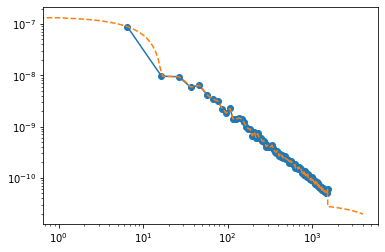

In [5]:
plt.loglog(ell_ee, cell_func(ell_ee))
plt.loglog(range(4000), cell_func(range(4000)), '--')
plt.scatter(ell_ee, cell_ee)

In [6]:
lmax_test = 64*3-1

In [7]:
cell_ee_test = cell_func(range(lmax_test))

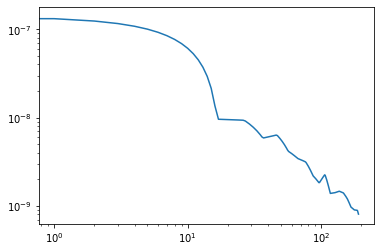

In [8]:
plt.loglog(range(lmax_test), cell_ee_test)

In [9]:
map_EE_test = hp.synfast(cell_ee_test, 32, 32*3-1) 

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/Users/ucapnje/anaconda3/lib/python3.6/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


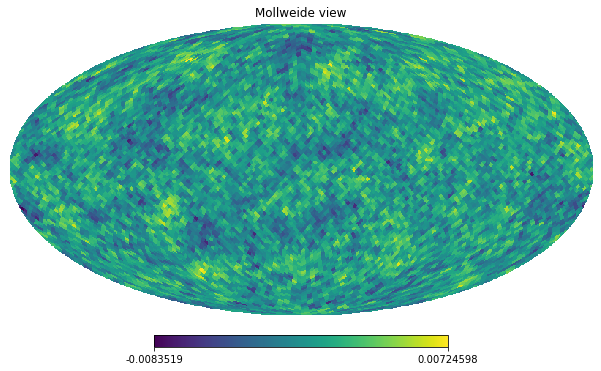

In [10]:
hp.mollview(map_EE_test)

In [11]:
map_QU_test = teb2iqu(np.array([map_EE_test*0.,
                                map_EE_test,
                                map_EE_test*0.]),
                      32, lmax=32*3-1)

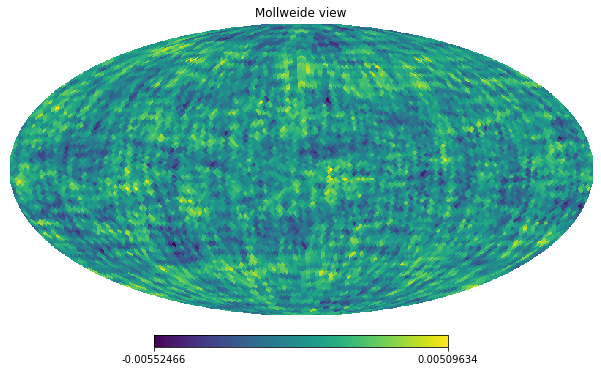

In [12]:
hp.mollview(map_QU_test[1])

In [13]:
test = hp.map2alm(map_QU_test[1]+map_QU_test[2], lmax=32*3-1)

In [14]:
n_iter = 500
cov_qu = np.zeros((test.shape[0],test.shape[0]), dtype='complex')
alm_mean = np.zeros((test.shape[0]))
for i in range(n_iter):
    if i%50==0:
        print(i)
        
    map_EE_test = hp.synfast(cell_ee_test, 32, 32*3-1, verbose=False) 
    map_QU_test = teb2iqu(np.array([map_EE_test*0.,
                                map_EE_test,
                                map_EE_test*0.]),
                      32, lmax=32*3-1)
    alm_test = hp.map2alm(map_QU_test[1]+map_QU_test[2], lmax=32*3-1)
    cov_qu += np.outer(alm_test, np.conj(alm_test)) *(1./np.float(n_iter))

0


KeyboardInterrupt: 

In [ ]:
_ = plt.figure(figsize=(12,4))
_ = plt.subplot(1,2,1), plt.imshow(np.real(cov_qu), clim=(-1e-9,1e-8)), plt.colorbar()
_ = plt.subplot(1,2,2), plt.imshow(np.imag(cov_qu), clim=(-1e-9,1e-8)), plt.colorbar()

## 2) Check that $C_{E,E}=C_{Q+iU,Q+iU}$ for B-mode-free map

In [15]:
def radial_profile(data):
    """
    Compute the radial profile of 2d image
    :param data: 2d image
    :return: radial profile
    """
    center = data.shape[0]/2
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center)**2 + (y - center)**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile / data.shape[0]**2

In [16]:
map_EE_test2 = hp.synfast(cell_func(range(128*3-1)), 128, 128*3-1) 

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [17]:
map_QU_test2 = teb2iqu(np.array([map_EE_test2*0.,
                                map_EE_test2,
                                map_EE_test2*0.]),
                       128, lmax=128*3-1)

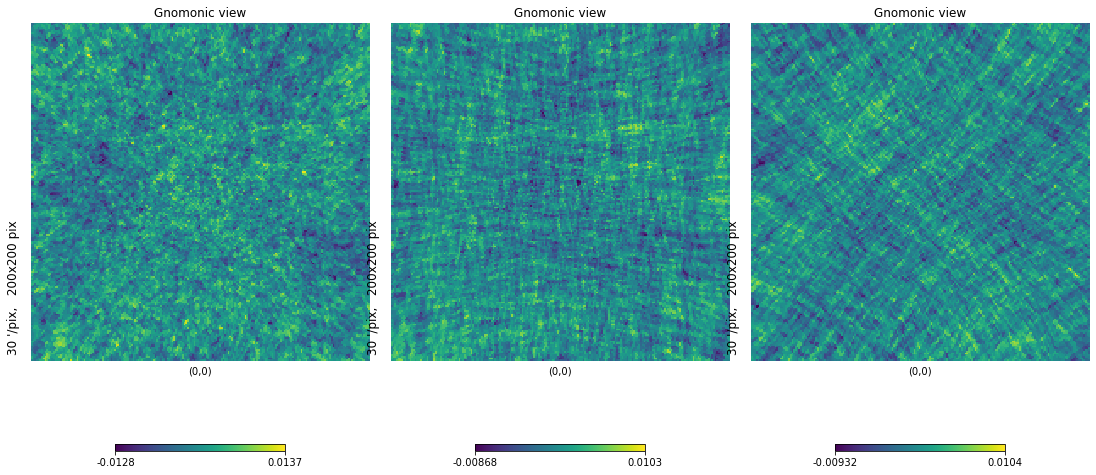

In [18]:
_ = plt.figure(figsize=(15,15))
E_projected = hp.gnomview(map_EE_test2, sub=(1,3,1), reso=30, return_projected_map=True)
q_projected = hp.gnomview(map_QU_test2[1], sub=(1,3,2), reso=30, return_projected_map=True)
u_projected = hp.gnomview(map_QU_test2[2], sub=(1,3,3), reso=30, return_projected_map=True)

In [19]:
measured_cell_power = hp.anafast(map_QU_test2[1]) +  hp.anafast(map_QU_test2[2])

In [20]:
_ = plt.loglog(measured_power)
_ = plt.loglog(cell_func(range(128*3-1)))

NameError: name 'measured_power' is not defined

In [ ]:
power_ee = np.fft.fftshift(np.fft.fft2(E_projected))
power_ee = radial_profile(np.real(power_ee*np.conj(power_ee)))

power_ququ = np.fft.fftshift(np.fft.fft2(q_projected+1j*u_projected))
power_ququ = radial_profile(np.real(power_ququ*np.conj(power_ququ)))

In [ ]:
_ = plt.loglog(power_ee)
_ = plt.loglog(power_ququ)

# T covariance is harmonic space

In [ ]:
random_T_field = np.random.normal(0., np.sqrt(1.6734788020439774e-05), hp.nside2npix(128))

In [ ]:
np.var(random_T_field)

In [ ]:
random_T_field_harmonic = hp.map2alm(random_T_field, lmax = 128*3-1)

In [ ]:
print(np.mean(random_T_field_harmonic))
print(np.var(random_T_field_harmonic))

In [21]:
0.00025096172691193913*(128*128.)

4.111756933725211

In [24]:
1.6816299101971316e-06/1.0586172499741844e-10

15885.15500043231

In [ ]:
1.6816299101971316e-05/1.0528145998140147e-09

In [ ]:
print(random_T_field_harmonic.shape[0])

In [ ]:
73920*2

In [25]:
ratio = []
for nside_test in [32, 64,128,256, 512]:
    random_T_field = np.random.normal(0., np.sqrt(4.), hp.nside2npix(nside_test))
    random_T_field_harmonic = hp.map2alm(random_T_field, lmax = nside_test*3-1)
    ratio.append(4.0/np.var(random_T_field_harmonic))

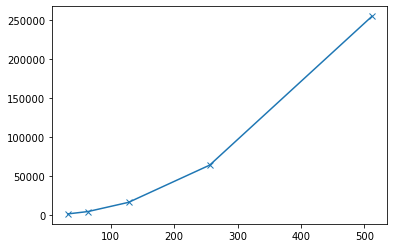

In [26]:
plt.plot([32, 64,128,256, 512], ratio, marker = 'x')

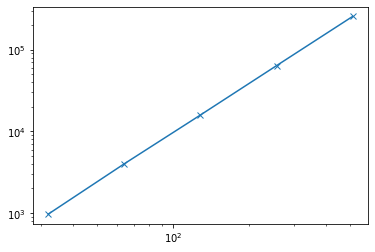

In [27]:
plt.loglog([32, 64,128,256, 512], ratio, marker = 'x')

In [28]:
from scipy import optimize

def test_func(x, a, b, c):
    return a * (x**b) + c

params, params_covariance = optimize.curve_fit(test_func, [32, 64,128,256, 512], ratio)

In [29]:
params

array([  0.96569577,   2.00146249, -10.1247288 ])

In [ ]:
params_covariance

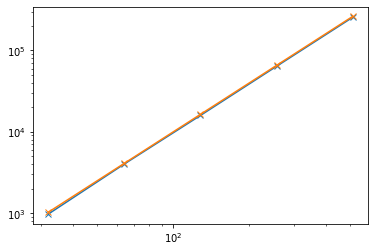

In [230]:
plt.loglog(np.array([32, 64,128,256, 512]),
         ratio, marker = 'x')

plt.plot(np.array([32, 64,128,256, 512]),
         np.array([32, 64,128,256, 512])**2.,
         marker = 'x')

## 3) Check what T_{EB}

In [216]:
random_T_field = np.random.normal(0., np.sqrt(4), hp.nside2npix(128))
random_T_field  = hp.ud_grade(random_T_field, 128)

In [217]:
foo, random_T_field_E, random_T_field_B  = iqu2teb([random_T_field*0.,random_T_field, random_T_field],
                                                   128, lmax=128*3-1)

random_T_field_E = hp.ud_grade(random_T_field_E, 128)
random_T_field_B = hp.ud_grade(random_T_field_B, 128)

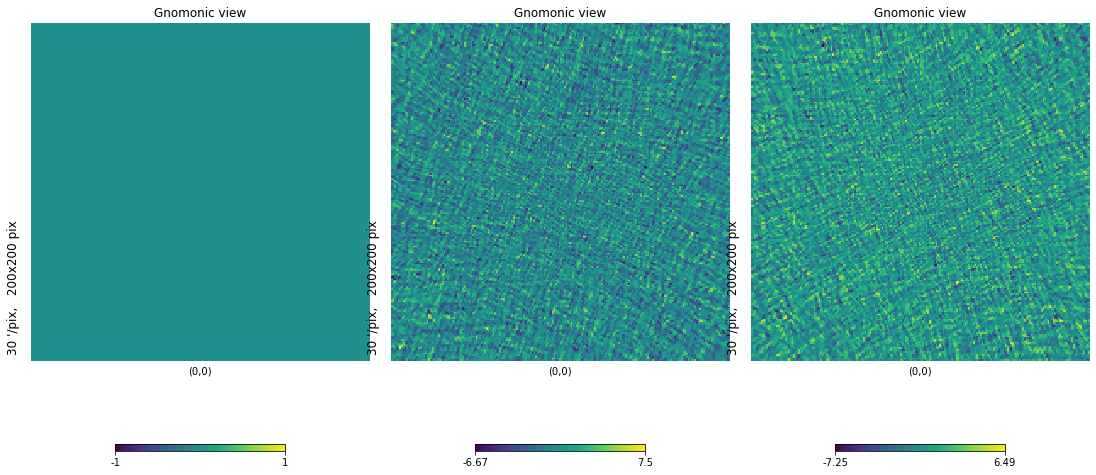

In [218]:
_ = plt.figure(figsize=(15,15))
_ = hp.gnomview(foo, sub=(1,3,1), reso=30, return_projected_map=True)
_ = hp.gnomview(random_T_field_E, sub=(1,3,2), reso=30, return_projected_map=True)
_ = hp.gnomview(random_T_field_B, sub=(1,3,3), reso=30, return_projected_map=True)

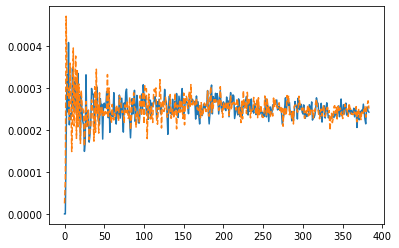

In [219]:
power_t_ee = hp.anafast(hp.ud_grade(random_T_field_E,128), lmax = 128*3-1)
power_t_qq = hp.anafast(hp.ud_grade(random_T_field,128), lmax = 128*3-1)
plt.plot(power_t_ee)
plt.plot(power_t_qq, '--')

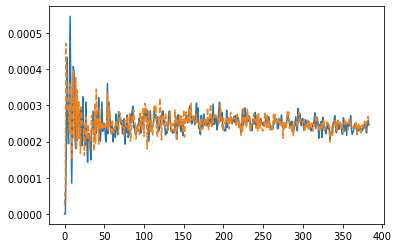

In [221]:
power_t_bb = hp.anafast(hp.ud_grade(random_T_field_B,128), lmax = 128*3-1)
power_t_qq = hp.anafast(hp.ud_grade(random_T_field,128), lmax = 128*3-1)
plt.plot(power_t_bb)
plt.plot(power_t_qq, '--')

In [222]:
print(np.mean(power_t_ee[4:]), np.mean(power_t_bb[4:]), np.mean(power_t_qq[4:]))

0.0002512827004573218 0.0002501235097637688 0.00025105237247544695


In [223]:
print(np.var(random_T_field_E), np.var(random_T_field_B),np.var(random_T_field))

2.931925938186952 2.9215826628780213 3.9984474813908206


In [224]:
4./(128*128.)

0.000244140625

In [200]:
# loop over

1.8875457336827313e-10

In [226]:
ee_test = []
qq_test = []

for i in range(10):
    print(i)
    random_T_field = np.random.normal(0., np.sqrt(4), hp.nside2npix(128))
    foo, random_T_field_E, random_T_field_B  = iqu2teb([random_T_field*0.,random_T_field, random_T_field],
                                                   128, lmax=128*3-1)

    power_t_ee = hp.anafast(random_T_field_E, lmax = 128*3-1)
    power_t_qq = hp.anafast(random_T_field, lmax = 128*3-1)
    
    ee_test.append(np.mean(power_t_ee[4:]))
    qq_test.append(np.mean(power_t_qq[4:]))

0
1
2
3
4
5
6
7
8
9


In [229]:
print(np.mean(ee_test), np.mean(qq_test), np.std(ee_test), np.std(qq_test))

0.00025259968020017066 0.00025302156409521106 1.4848842411935912e-06 8.444205576447015e-07


In [228]:
4.0/(128*128.)

0.000244140625

In [233]:
ratio = []
cell_ratio = []

for nside_test in [32, 64,128,256, 512]:
    
    print(nside_test)
    
    random_T_field = np.random.normal(0., np.sqrt(4), hp.nside2npix(nside_test))
    
    foo, random_T_field_E, random_T_field_B  = iqu2teb([random_T_field*0.,random_T_field, random_T_field],
                                                   nside_test, nside_test*3-1)

    power_t_ee = hp.anafast(random_T_field_E, lmax = nside_test*3-1)
    ratio.append(4.0/np.var(random_T_field_E))
    cell_ratio.append(4.0/np.mean(power_t_ee[4:]))
    

32
64
128
256
512


In [234]:
ratio

[1.3318916361953548,
 1.3429074113753838,
 1.3535512772202483,
 1.361796890812594,
 1.361287723235632]

In [240]:
np.array(cell_ratio)/(np.array([32, 64,128,256, 512])**2.)

array([0.94809075, 0.96358099, 0.95544795, 0.96485509, 0.96753668])

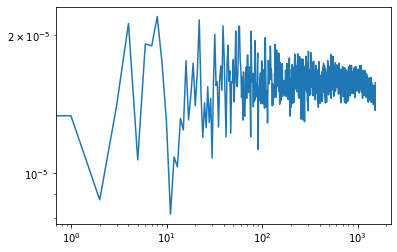

In [237]:
plt.loglog(power_t_ee[4:])

In [238]:
np.var(random_T_field_E)

2.9383942363723357